In [1]:
%pip install langgraph

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/df/3d/d6034923e0a03aa406b067e4777b611ffc65a8906a2efa214e845b3f84d4/langgraph-0.2.74-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-core!=0.3.0,!=0.3.1,!=0.3.10,!=0.3.11,!=0.3.12,!=0.3.13,!=0.3.14,!=0.3.15,!=0.3.16,!=0.3.17,!=0.3.18,!=0.3.19,!=0.3.2,!=0.3.20,!=0.3.21,!=0.3.22,!=0.3.3,!=0.3.4,!=0.3.5,!=0.3.6,!=0.3.7,!=0.3.8,!=0.3.9,<0.4.0,>=0.2.43 from https://files.pythonhosted.org/packages/6a/f5/9ce2a94bc49b64c0bf53b17524d5fc5c926070e911b11d489979d47d5491/langchain_core-0.3.37-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph-checkpoint<3.0.0,>=2.0.10 from https://files.pythonhosted.org/packages/7c/63/03bc3dd304ead45b53313cab8727329e1d139a2d220f2d030c72242c860e/langgraph_checkpoint-2.0.16-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph-sdk<0.2.0,>=0.1.42 from https://files.pythonhosted.org/packages/fc/97/3492a07b45

In [6]:
from dotenv import load_dotenv
from anthropic import Anthropic

import os

load_dotenv(os.path.abspath(os.path.join(os.getcwd(), "../.env")))

client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))


def get_messages(prompt, system_prompt="") -> str:
    return client.messages.create(
        model="claude-3-5-haiku-20241022",
        messages=prompt,
        max_tokens=1024 * 2,
        temperature=0.7,
        system=system_prompt
    ).content[0].text


In [14]:
def plan_essay(prompt):
    system_prompt = """
    당신은 주어진 주제에 대해 체계적인 에세이 계획을 작성하는 AI 어시스턴트입니다.
    에세이 구조는 서론, 본론, 결론으로 구성되며, 각 부분에 대한 핵심 아이디어와 주요 논점을 포함해야합니다.
    사용자가 주제를 제공하면, 이에 맞는 상세한 에세이 플랜을 작성해주세요.
    """

    return get_messages(prompt, system_prompt)

In [15]:
def generate_essay(message):
    system_prompt = """
    당신은 훌륭한 5단락 에세이를 작성하는 에세이 어시스턴트 AI 입니다.
    사용자의 요청이나 제공된 에세이 계획에 따라서, 최고의 에세이를 작성해주세요.
    사용자가 에세이 계획을 제공하면, 그 구조의 핵심 포인트를 반영해 에세이를 작성해주세요.
    사용자가 피드백을 제공하면, 이전 시도를 수정해 개선된 버전으로 응답하세요.

    서론에는 해당 주제의 지식이 왜 필요한지, 경험이나 중요성을 언급해주세요.
    본론에서는 여러가지 해결책 중 하나를 선택하고, 선택한 이유에 대해서 설명해주세요.
    """

    return get_messages(message, system_prompt)

In [8]:
def feedback_essay(message):
    system_prompt = """
    당신은 에세이 제출을 검사하는 경험 많은 편집장입니다.
    학생의 에세이를 비판적으로 분석하고, 강점과 개선이 필요한 부분을 모두 강조해 건설적인 피드백을 제공해주세요.
    내용의 깊이, 논증의 일관성, 논리적 흐름, 문제, 문법 등의 측면에서 상세하고 구체적인 개선사항을 포함해주세요.
    """

    return get_messages(message, system_prompt)

In [17]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    topic: str
    plan: str
    essay: str
    feedback: str
    revision: int
    max_revision: int


def plan_node(state: State):
    message = [
        {
            "role": "user",
            "content": state["topic"]
        }
    ]

    return {"plan": plan_essay(message)}


def generate_node(state: State):
    plan = state["plan"]
    essay = state.get("essay", "")
    feedback = state.get("feedback", "")

    if essay == "":
        return {"essay": generate_essay([
            {
                "role": "user",
                "content": f"<plan>{plan}</plan>"
            }
        ])}

    return {"essay": generate_essay([
        {
            "role": "user",
            "content": f"<essay>{essay}</essay>\n<feedback>{feedback}</feedback>"
        }
    ])}


def feedback_node(state: State):
    essay = state.get("essay", "")

    return {
        "feedback": feedback_essay([
            {
                "role": "user",
                "content": f"<essay>{essay}</essay>"
            }
        ]),
        "revision": state["revision"] + 1
    }

def should_continue(state: State):
    if state["revision"] >= state["max_revision"]:
        return END
    return "reflect"

builder = StateGraph(State)
builder.add_node("essay_plan", plan_node)
builder.add_node("generate", generate_node)
builder.add_node("reflect", feedback_node)

builder.add_edge(START, "essay_plan")
builder.add_edge("essay_plan", "generate")
builder.add_edge("reflect", "generate")
builder.add_conditional_edges("generate", should_continue)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

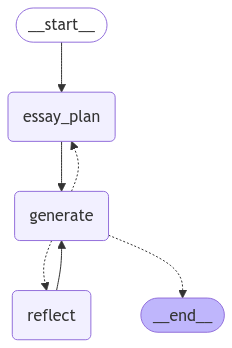

In [12]:
from IPython.display import display
from IPython.core.display import Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
thread = {"configurable": {"thread_id": "1"}}

for i in graph.stream({
    "topic": "SpringBoot JPA 환경에서 자연키와 대리키중 어느 것을 PK로 하는 것이 좋을까?",
    "max_revision": 3,
    "revision": 1
}, thread):
    print(i)

{'essay_plan': {'plan': '에세이 제목: "SpringBoot JPA 환경에서 기본키 선택: 자연키 vs 대리키"\n\nI. 서론\n1. 기본키 선택의 중요성 소개\n2. 자연키와 대리키의 개념 간단 설명\n3. 논문의 핵심 질문: 어떤 키를 선택하는 것이 더 효과적인가?\n\nII. 본론 1: 자연키의 특징과 한계\n1. 자연키의 정의\n   - 실제 비즈니스 속성을 활용한 키\n   - 예: 주민등록번호, 이메일 등\n\n2. 자연키의 장점\n   - 직관적이고 이해하기 쉬움\n   - 중복 방지 가능성\n\n3. 자연키의 단점\n   - 변경 가능성\n   - 보안 문제\n   - 성능 저하 위험\n\nIII. 본론 2: 대리키(인조키)의 특징\n1. 대리키의 정의\n   - 인위적으로 생성된 고유 식별자\n   - 주로 auto_increment나 UUID 사용\n\n2. 대리키의 장점\n   - 불변성\n   - 성능 최적화\n   - 데이터 보안\n   - 확장성\n\n3. 대리키 구현 방식\n   - @GeneratedValue\n   - UUID\n   - SEQUENCE 전략\n\nIV. 본론 3: SpringBoot JPA 관점에서의 권장사항\n1. JPA 표준 권장 사항\n2. 대리키 사용의 이점\n3. 실무적 관점의 접근\n\nV. 결론\n1. 대리키 사용 권장\n2. 선택 기준 요약\n3. 최종 제언: 상황과 요구사항에 따른 유연한 접근\n\n핵심 권장사항:\n- 대부분의 경우 대리키(인조키) 사용 권장\n- 고유하고 불변한 키 선택\n- 성능과 확장성 고려'}}
{'generate': {'essay': '# SpringBoot JPA 환경에서 기본키 선택: 자연키 vs 대리키\n\n데이터베이스 설계에서 기본키 선택은 애플리케이션의 성능과 확장성을 결정짓는 중요한 의사결정입니다. 개발자로서 필자는 수많은 프로젝트에서 이 딜레마를 직면해왔고, 그 경험을 바탕으로 기본키 선택의 핵심 원칙을 공유하고자 합니다.\n\n자연키와